<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RS_gr1/blob/main/Marfida%20Alexander/Staj_profpatolog_4_(Functional_API_%3D_norm_1b%2Bohe_1b).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Стажировка. Профпатолог (INSPECTRUM CLINIC)
- Funtcional API для 2-х выборок:
  - нормированной и категориальной - без удаления NaN в целевом столбце балансированных дублированием и равномерным перемешиванием.
- Целевые категории:
  - Годен
  - Не годен
  - Ограниченно годен
  - Недостаточно данных для заключения

# ЗАГРУЗКА БИБЛИОТЕК И ДАТАСЕТОВ

In [ ]:
# Подключение библиотек

# Работа с массивами данных
import numpy as np

# Работа с табличными данными
import pandas as pd

# Функции-утилиты для работы с категориальными данными
from keras.api._v2.keras import utils
from keras.api._v2.keras.utils import to_categorical

# Класс для конструирования последовательной модели нейронной сети
from keras.api._v2.keras.models import Sequential, Model

# Основные слои
from keras.api._v2.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from keras.api._v2.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Оптимизаторы
from keras.api._v2.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор для преобразования текстов в последовательности
from keras.api._v2.keras.preprocessing.text import Tokenizer

# Предварительная обработка данных
# from sklearn import preprocessing

# Масштабирование данных
from sklearn.preprocessing import StandardScaler

#from sklearn.datasets import fetch_openml
#from sklearn.model_selection import cross_val_predict
#from sklearn.linear_model import SGDClassifier

# Загрузка датасетов из облака google
import gdown

# Регулярные выражения
import re

# Связь с google-диском
from google.colab import files

# Отрисовка графиков
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Создание статистических графиков
import seaborn as sns

# Табличные данные
from fastai.tabular import *

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Разделение данных на выборки
from sklearn.model_selection import train_test_split

# Очистка экрана
from IPython.display import clear_output

# Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline

In [ ]:
# Монтирование Goodle-диска
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# СЛУЖЕБНЫЕ ФУНКЦИИ

## Загрузка датасетов

In [ ]:
x_train_norm_1b = np.load('/content/drive/MyDrive/УИИ(marphida)/Стажировка_Профпатолог/x_train_norm_1b.npy')
x_train_ohe_1b = np.load('/content/drive/MyDrive/УИИ(marphida)/Стажировка_Профпатолог/x_train_ohe_1b.npy')
y_train_ohe_1b = np.load('/content/drive/MyDrive/УИИ(marphida)/Стажировка_Профпатолог/y_train_ohe_1b.npy')
print(x_train_norm_1b.shape)
print(x_train_ohe_1b.shape)
print(y_train_ohe_1b.shape)

(5730, 69)
(5730, 1987)
(5730, 4)


## Функция графиков обучения

In [ ]:
def graphic(loss, accuracy, valloss, valaccuracy, scor, scorloss, exp, param):
  print(
    f'Входных Нейронов: {param[0]}\n',
    f'Значение Dropout: {param[1]}\n',
    f'BatchNormalization: {param[2]}\n',
    f'Средние потери: {param[3]}\n',
    f'Средняя точность на тестовой выборке: {param[4]}\n'
  )
  print('↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓')

  plt.figure(1, figsize=(20, 5))

  plt.subplot(1, 2, 1)
  plt.plot(accuracy, label='Доля верных ответов(train)')
  plt.plot(valaccuracy, label='Доля верных ответов(val)')
#  plt.scatter(19, scor/100, c='r')
  plt.title(f'Опыт№ {exp+1}. Параметры модели: {param}')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.grid(color='gray', linestyle=':')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(loss, label='train_loss')
  plt.plot(valloss, label='val_loss')
#  plt.scatter(19, scorloss, c='r')
  plt.title(f'Опыт№ {exp+1}, loss')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Ошибка')
  plt.legend()
  plt.grid(color='gray',linestyle=':')
  print()
  plt.show()

## Функция создания модели

In [ ]:
def сreatModel(numN, drop, norm=False, layer2=0, layer3=0):

    # Создание последовательной модели
    model = Sequential()

    if norm:
        model.add(BatchNormalization(input_shape=(x_train.shape[1], )))
        model.add(Dense(numN, activation="relu"))
    else:
        model.add(Dense(numN, input_dim=x_train.shape[1], activation="relu"))

    if layer2 > 0:
      model.add(Dense(numN*layer2, input_dim=x_train.shape[1], activation="relu"))
    elif layer2 < 0:
      model.add(Dense(int(numN/(-layer2)), input_dim=x_train.shape[1], activation="relu"))

    if layer3 > 0:
      model.add(Dense(numN*layer2, input_dim=x_train.shape[1], activation="relu"))
    elif layer3 < 0:
      model.add(Dense(int(numN/(-layer2)), input_dim=x_train.shape[1], activation="relu"))

    model.add(Dropout(drop))
    model.add(Dense(4, activation="softmax")) #

    # Компиляция модели
    model.compile(loss="categorical_crossentropy",
                    optimizer="adam",
                    metrics=["accuracy"])
    return model

## Функция обучения и тестирования модели

In [ ]:
def training(dense_list, drop_list, norm_list, layer2=0, layer3=0):

  parameters = []
  val_accuracy= []
  val_loss_ = []
  accuracy= []
  loss_ = []

  for numN in dense_list:
    for norm in norm_list:
      for drop in drop_list:

        print('Параметры модели: вх.нейр.=', numN, '; откл.нейр.=', drop, '; BatchNormalization=', norm)

        # Создание последовательной модели
        model = сreatModel(numN, drop, norm=norm, layer2=layer2, layer3=layer3)

        # Обучение модели
        history = model.fit(x_train,    # обучающая выборка экземпляры класса
                  y_train,              # обучающая выборка метки класса
                  batch_size=128,       # размер батча
                  epochs=20,            # количество эпох
                  verbose=1,            # 0 - не показывать ход обучения, 1 - показывать
                  validation_data=(x_val, y_val) # выборка для валидации
                  )
        scores = model.evaluate(x_test, y_test)
        print('Точность на тестовой выборке:', scores[1] )

        parameters.append([numN, drop, norm, round(scores[0], 4), round(scores[1], 4)*100])
        val_accuracy.append(history.history['val_accuracy'])
        val_loss_.append(history.history['val_loss'])
        accuracy.append(history.history['accuracy'])
        loss_.append(history.history['loss'])

  return parameters, accuracy, loss_, val_accuracy, val_loss_

## Разделение на обучающую, валидационную и тестовую выборки

In [ ]:
X_tr_n = x_train_norm_1b.copy()
X_tr_o = x_train_ohe_1b.copy()
Y_tr_o = y_train_ohe_1b.copy()

### Для модели с нормированными и категориальными данными

In [ ]:
train_sep = int(X_tr_n.shape[0] * 0.9)

print('X_tr_n.shape = ', X_tr_n.shape)
print('X_tr_o.shape = ', X_tr_o.shape)
print('Y_tr_o.shape = ', Y_tr_o.shape)
print()

x_train_n, x_test_n, x_train_o, x_test_o, y_train, y_test =  \
  X_tr_n[:train_sep], X_tr_n[train_sep:], X_tr_o[:train_sep], X_tr_o[train_sep:], Y_tr_o[:train_sep], Y_tr_o[train_sep:]

print('x_train_n.shape = ', x_train_n.shape)
print('x_train_o.shape = ', x_train_o.shape)
print('y_train.shape = ', y_train.shape)
print('x_test_n.shape = ', x_test_n.shape)
print('x_test_o.shape = ', x_test_o.shape)
print('y_test.shape', y_test.shape)
print()
val_sep = int(x_train_n.shape[0] * 0.8)

x_train_n, x_train_o, x_val_n, x_val_o, y_train, y_val = \
  x_train_n[:val_sep], x_train_o[:val_sep], x_train_n[val_sep:], x_train_o[val_sep:], y_train[:val_sep], y_train[val_sep:]

print('x_train_n.shape = ', x_train_n.shape)
print('x_train_o.shape = ', x_train_o.shape)
print('y_train.shape = ', y_train.shape)
print('x_val_n.shape = ', x_val_n.shape)
print('x_val_o.shape = ', x_val_o.shape)
print('y_val.shape', y_val.shape)


X_tr_n.shape =  (5730, 69)
X_tr_o.shape =  (5730, 1987)
Y_tr_o.shape =  (5730, 4)

x_train_n.shape =  (5157, 69)
x_train_o.shape =  (5157, 1987)
y_train.shape =  (5157, 4)
x_test_n.shape =  (573, 69)
x_test_o.shape =  (573, 1987)
y_test.shape (573, 4)

x_train_n.shape =  (4125, 69)
x_train_o.shape =  (4125, 1987)
y_train.shape =  (4125, 4)
x_val_n.shape =  (1032, 69)
x_val_o.shape =  (1032, 1987)
y_val.shape (1032, 4)


### Для модели только с категориальными данными


In [ ]:
train_sep = int(X_tr_n.shape[0] * 0.8901)
print('train_sep = ', train_sep)
tr_05 = int(train_sep / 2)
print('tr_05 = ', tr_05)

x_train_o, x_test_o = X_tr_o[:train_sep], X_tr_o[train_sep:]
print('x_train_o.shape = ', x_train_o.shape)
print('x_test_o.shape = ', x_test_o.shape)

x_train_o_1, x_train_o_2 = x_train_o[:tr_05], x_train_o[tr_05:]
print('x_train_o_1.shape = ', x_train_o_1.shape)
print('x_train_o_2.shape = ', x_train_o_2.shape)

y_train, y_test = Y_tr_o[:train_sep], Y_tr_o[train_sep:]
print('y_train.shape = ', y_train.shape)
print('y_test.shape = ', y_test.shape)


In [ ]:
print('x_train_n.shape = ', x_train_n.shape)
#x_train_n_o = x_train_n.reshape(-1)
#print('x_train_n_o.shape = ', x_train_n_o.shape)
x_train_n_o = to_categorical(x_train_n)
#x_train_n_o = x_train_n.reshape(3667, -1)
print('x_train_n_o.shape = ', x_train_n_o.shape)
x_train_n_o = x_train_n.reshape(4125, -1)
print('x_train_n_o.shape = ', x_train_n_o.shape)


x_train_n.shape =  (4125, 69)
x_train_n_o.shape =  (4125, 69, 1)
x_train_n_o.shape =  (4125, 69)


## Построение модели Functional API

In [ ]:
# input1 = Input((x_train_n_o.shape[1],))
input1 = Input((x_train_n.shape[1],))
#print('x_train_n_o.shape[1] = ', x_train_n_o.shape[1])
print('x_train_n.shape[1] = ', x_train_n.shape[1])
#input1 = Input((x_val_o.shape[1],))
input2 = Input((x_train_o.shape[1],))
print('x_train_o.shape[1] = ', x_train_o.shape[1])

x1 = input1                               # Ветка 1
x1 = Dense(64, activation="relu")(x1)
# x1 = Dense(32, activation="linear")(x1)

x2 = input2                               # Ветка 2
x2 = Dense(64, activation="relu")(x2)

x = concatenate([x1, x2])             # Объединение веток

x = Dense(64, activation='relu')(x)       # Промежуточный слой
# x = Dense(32, activation='linear')(x)       # Промежуточный слой
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)      # Финальный регрессирующий нейрон

model_final = Model((input1, input2), x)

x_train_n.shape[1] =  69
x_train_o.shape[1] =  1987


In [ ]:
model_final.compile(optimizer=Adam(learning_rate=1e-3),
                    # loss="categorical_crossentropy",
                    # loss="sparse_categorical_crossentropy",
                    loss=['mse', 'hinge'],
                    metrics=['accuracy', 'mae']
                    # loss='mse'
                    # metrics=['mae']
                    )

history = model_final.fit([x_train_n, x_train_o],
# history = model_final.fit([x_train_n_o, x_train_o],
# history = model_final.fit([x_train_n_o, x_train_o], [x_train_o, x_train_n_o],
# history = model_final.fit([x_val_o, x_train_o],
                           y_train,
                           batch_size=128,
                           epochs=20,
                           validation_split=0.15,
#                           validation_data=(x_val_o, y_val),
                           verbose=1)


Epoch 1/20
28/28 [==============================] - 6s 13ms/step - loss: 0.1294 - accuracy: 0.6594 - mae: 0.2854 - val_loss: 0.0690 - val_accuracy: 0.8837 - val_mae: 0.1829
Epoch 2/20
28/28 [==============================] - 0s 6ms/step - loss: 0.0517 - accuracy: 0.8965 - mae: 0.1382 - val_loss: 0.0414 - val_accuracy: 0.9015 - val_mae: 0.0878
Epoch 3/20
28/28 [==============================] - 0s 6ms/step - loss: 0.0287 - accuracy: 0.9395 - mae: 0.0771 - val_loss: 0.0357 - val_accuracy: 0.9031 - val_mae: 0.0674
Epoch 4/20
28/28 [==============================] - 0s 6ms/step - loss: 0.0217 - accuracy: 0.9527 - mae: 0.0624 - val_loss: 0.0283 - val_accuracy: 0.9257 - val_mae: 0.0565
Epoch 5/20
28/28 [==============================] - 0s 6ms/step - loss: 0.0164 - accuracy: 0.9649 - mae: 0.0486 - val_loss: 0.0254 - val_accuracy: 0.9402 - val_mae: 0.0476
Epoch 6/20
28/28 [==============================] - 0s 6ms/step - loss: 0.0126 - accuracy: 0.9720 - mae: 0.0381 - val_loss: 0.0227 - val_ac

In [ ]:
scores = model_final.evaluate(x_test_o, y_test)
# print(model_final.predict(x_test_o[1], y_test[1]))
# print('Точность на тестовой выборке:', scores[1] )


ValueError: ignored

### Схема модели

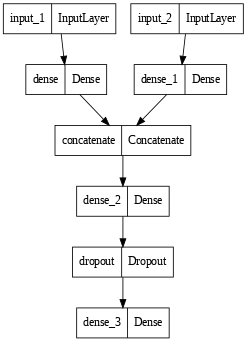

In [ ]:
utils.plot_model(model_final, dpi=60)

===============================================================================================================